# Figure showing the posterior validations

In [1]:
import os, glob
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch
from haloflow import data as D
from haloflow import util as U

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

In [ ]:
qphis0 = U.read_best_ndes('msmh.v1.mags.maf', device=device)
qphis1 = U.read_best_ndes('msmh.v1.mags_morph.maf', device=device)
#qphis2 = U.read_best_ndes('msmh.v1.mags_morph_satlum_all.maf', device=device)
#qphis3 = U.read_best_ndes('msmh.v1.mags_morph_satlum_all_rich_all.maf', device=device)
qphis2 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrlim.maf', device=device)
qphis3 = U.read_best_ndes('msmh.v1.mags_morph_satlum_mrliml_rich_mrlim.maf', device=device)

In [ ]:
y0, x0 = D.get_subhalos('test', 'mags', snapshot=91)
y1, x1 = D.get_subhalos('test', 'mags_morph', snapshot=91)
#y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_all', snapshot=91)
#y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_all_rich_all', snapshot=91)
y2, x2 = D.get_subhalos('test', 'mags_morph_satlum_mrlim', snapshot=91)
y3, x3 = D.get_subhalos('test', 'mags_morph_satlum_mrlim_rich_mrlim', snapshot=91)

In [ ]:
n_sample = 10000

ranks0, ranks1, ranks2, ranks3 = [], [], [], []
y_nde0, y_nde1, y_nde2, y_nde3 = [], [], [], []

for i in trange(y0.shape[0]): 
    for qphis, ranks, y_nde, xs, ys in zip([qphis0, qphis1, qphis2, qphis3], 
                                           [ranks0, ranks1, ranks2, ranks3], 
                                           [y_nde0, y_nde1, y_nde2, y_nde3], 
                                           [x0, x1, x2, x3], [y0, y1, y2, y3]): 
        y_samp = []
        for qphi in qphis: 
            nmlim, nx = 0, 1
            while nmlim < (n_sample/len(qphis0)):
                _samp = qphi.sample((int(nx * n_sample/len(qphis0)),),
                                   x=torch.tensor(xs[i], dtype=torch.float32).to(device), 
                                   show_progress_bars=False)
                _sam = _samp.detach().cpu().numpy()
                
                nmlim = np.sum(_sam[:,0] > 9.5)
                nx *= 2 
            
            i_sam = np.random.choice(np.arange(_sam.shape[0])[_sam[:,0] > 9.5], 
                                     size=int(n_sample/len(qphis0)), replace=False)                
            y_samp.append(_sam[i_sam])
        y_nde.append(np.concatenate(np.array(y_samp), axis=0))        
    
        _ranks = []
        for i_dim in range(y_nde[-1].shape[1]): 
            _ranks.append(np.mean(y_nde[-1][:,i_dim].flatten() < ys[i, i_dim]))
        ranks.append(_ranks)
    
ranks0 = np.array(ranks0)
ranks1 = np.array(ranks1)
ranks2 = np.array(ranks2)
ranks3 = np.array(ranks3)

y_nde0 = np.array(y_nde0)
y_nde1 = np.array(y_nde1)
y_nde2 = np.array(y_nde2)
y_nde3 = np.array(y_nde3)

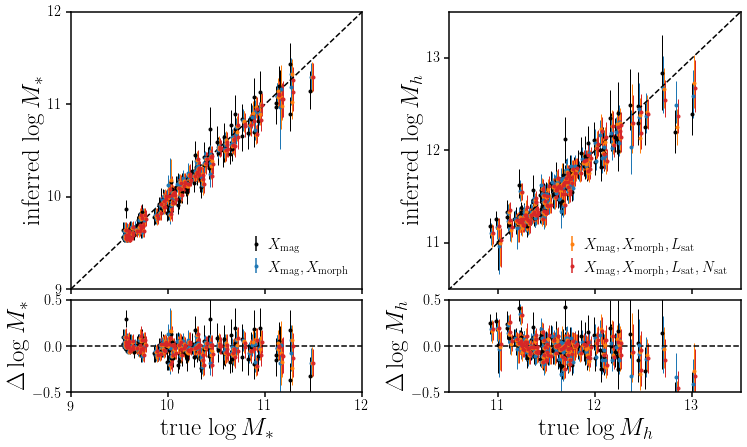

In [41]:
i_ms_bin = np.arange(ys.shape[0])[::5]#np.array([np.argmin((ys[:,0] - ms)**2) for ms in np.linspace(9.5, 11.5, 21)])
i_mh_bin = np.arange(ys.shape[0])[::5]# np.array([np.argmin((ys[:,1] - mh)**2) for mh in np.linspace(11, 13.25, 19)])

fig, subs = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12,7))
#sub = fig.add_subplot(121)
sub = subs[0,0]

for i, ys, y_nde, clr in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2, q3 = np.quantile(y_nde[i_ms_bin,:,0], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[i_ms_bin,0]+0.01*i, q2, yerr=[q2-q1, q3-q2], fmt='.%s' % clr, lw=1)
    
sub.plot([9., 15], [9., 15], c='k', ls='--')

sub.errorbar([], [], yerr=[], fmt='.k', label=r'$X_{\rm mag}$')
sub.errorbar([], [], yerr=[], fmt='.C0', label=r'$X_{\rm mag}, X_{\rm morph}$')
sub.legend(loc='lower right', handletextpad=-0.2, fontsize=15)

#sub.set_xlabel(r'true $\log M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_xticks([9., 10., 11., 12.])
sub.set_xticklabels([])
sub.set_ylabel(r'inferred $\log M_*$', fontsize=25)
sub.set_ylim(9., 12.)
sub.set_yticks([9., 10., 11., 12.])

sub = subs[1,0]
for i, ys, y_nde, clr in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2, q3 = np.quantile(y_nde[i_ms_bin,:,0], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[i_ms_bin,0]+0.01*i, q2-ys[i_ms_bin,0], yerr=[q2-q1, q3-q2], fmt='.%s' % clr, lw=1)
    
sub.plot([9., 15], [0., 0.,], c='k', ls='--')

sub.set_xlabel(r'true $\log M_*$', fontsize=25)
sub.set_xlim(9., 12.)
sub.set_xticks([9., 10., 11., 12.])
sub.set_ylabel(r'$\Delta \log M_*$', fontsize=25)
sub.set_ylim(-0.5, 0.5)
#sub.set_yticks([9., 10., 11., 12.])


#sub = fig.add_subplot(122)
sub = subs[0,1]
for i, ys, y_nde, clr in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2, q3 = np.quantile(y_nde[i_mh_bin,:,1], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[i_mh_bin,1]+0.01*i, q2, yerr=[q2-q1, q3-q2], fmt='.%s' % clr, lw=1)

sub.errorbar([], [], yerr=[], fmt='.C1', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat}$')
sub.errorbar([], [], yerr=[], fmt='.C3', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat}, N_{\rm sat}$')        

sub.legend(loc='lower right', handletextpad=-0.2, fontsize=15)

sub.plot([9., 15], [9., 15], c='k', ls='--')
#sub.set_xlabel(r'true $\log M_h$', fontsize=25)
sub.set_xlim(10.5, 13.5)
sub.set_xticks([11, 12, 13])
sub.set_xticklabels([])
sub.set_ylabel(r'inferred $\log M_h$', fontsize=25)
sub.set_ylim(10.5, 13.5)
sub.set_yticks([11, 12, 13])

sub = subs[1,1]
for i, ys, y_nde, clr in zip(range(4), [y0, y1, y2, y3], [y_nde0, y_nde1, y_nde2, y_nde3], ['k', 'C0', 'C1', 'C3']): 
    q1, q2, q3 = np.quantile(y_nde[i_ms_bin,:,1], (0.16, 0.5, 0.84), axis=1)
    sub.errorbar(ys[i_ms_bin,1]+0.01*i, q2-ys[i_ms_bin,1], yerr=[q2-q1, q3-q2], fmt='.%s' % clr, lw=1)
    
sub.plot([9., 15], [0., 0.,], c='k', ls='--')

sub.set_xlabel(r'true $\log M_h$', fontsize=25)
sub.set_xlim(10.5, 13.5)
sub.set_xticks([11, 12, 13])
sub.set_ylabel(r'$\Delta \log M_h$', fontsize=25)
sub.set_ylim(-0.5, 0.5)

fig.subplots_adjust(wspace=0.3, hspace=0.06)
fig.savefig('figs/valid_errorbar.pdf', bbox_inches='tight')

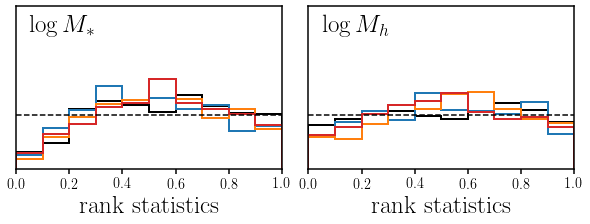

In [16]:
fig = plt.figure(figsize=(10, 3))
for i in range(2): 
    sub = fig.add_subplot(1,2,i+1)
    _ = sub.hist(ranks0[:,i], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='k') 
    _ = sub.hist(ranks1[:,i], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='C0') 
    _ = sub.hist(ranks2[:,i], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='C1') 
    _ = sub.hist(ranks3[:,i], range=(0., 1), bins=10, histtype='step', density=True, linewidth=2, color='C3') 
    
    sub.plot([0., 1.], [1., 1.], c='k', ls='--')
    
    sub.text(0.05, 0.95, [r'$\log M_*$', r'$\log M_h$'][i], fontsize=25, transform=sub.transAxes, ha='left', va='top')
    
    sub.set_xlabel('rank statistics', fontsize=25)
    sub.set_xlim(0., 1.)
    sub.set_ylim(0., 3.)
    sub.set_yticks([])
fig.subplots_adjust(hspace=0.1, wspace=0.1)
#fig.savefig('../figs/ranks_p_omega_x.pdf', bbox_inches='tight')

In [42]:
from tarp import get_drp_coverage

In [43]:
alpha0, ecp0 = get_drp_coverage(np.swapaxes(y_nde0, 0, 1), y0, references="random", metric="euclidean")
alpha1, ecp1 = get_drp_coverage(np.swapaxes(y_nde1, 0, 1), y1, references="random", metric="euclidean")
alpha2, ecp2 = get_drp_coverage(np.swapaxes(y_nde2, 0, 1), y2, references="random", metric="euclidean")
alpha3, ecp3 = get_drp_coverage(np.swapaxes(y_nde3, 0, 1), y3, references="random", metric="euclidean")

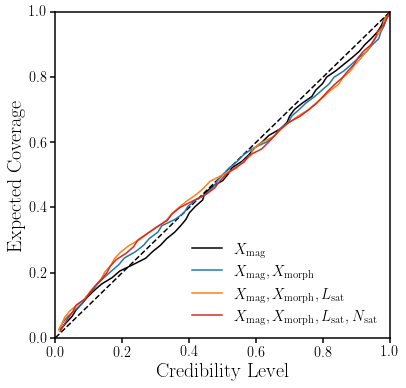

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.plot([0, 1], [0, 1], ls="--", color="k")
ax.plot(alpha0, ecp0, c='k', label=r'$X_{\rm mag}$')
ax.plot(alpha1, ecp1, c='C0', label=r'$X_{\rm mag}, X_{\rm morph}$')
ax.plot(alpha2, ecp2, c='C1', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat}$')
ax.plot(alpha3, ecp3, c='C3', label=r'$X_{\rm mag}, X_{\rm morph}, L_{\rm sat}, N_{\rm sat}$')
ax.legend(loc='lower right', fontsize=15)
ax.set_ylabel("Expected Coverage", fontsize=20)
ax.set_ylim(0., 1.)
ax.set_xlabel("Credibility Level", fontsize=20)
ax.set_xlim(0., 1.)
fig.savefig('figs/valid_tarp.pdf', bbox_inches='tight')